# Convolution on GPU

Modern machine learning is deeply intertwined with the concept of GPU computations. However, a GPU is not a magic button that automatically speeds up every operation. To fully harness the benefits of modern GPUs, algorithms must be carefully designed to run smoothly on these parallel architectures, leveraging concepts such as SIMD (Single Instruction, Multiple Data) along with other optimization techniques.

In this notebook, I will dive into the details of how to implement a convolution operation an essential component of convolution layers—specifically tailored to work efficiently on the GPU.

This work will include theory, code and evaluation of the algorithm. For the implementation I will use numpy and cupy as the main tool, and also I will research on the numba tool and evaluate the ways to optimize the algorithm even further.

In [60]:
import numpy as np
from matplotlib import pyplot as plt
import cupy as cp
import time

def clear_mem():
    mempool = cp.get_default_memory_pool()
    mempool.free_all_blocks()

## Basic Convolution Algorithm

In the introductory lectures to the Convolutional Neural Networks, the most basic algorithm is introduced: it slides over each patch along the $i$ and $j$ axes and accumulates the result of the matrix multiplication between the input patch and the convolution kernel. In mathematical terms, for a single chanel of input $I$ and kernel $K$, the output at position $(i,j)$ is computed as:

$$
O(i,j) = \sum_{m=0}^{k_h-1} \sum_{n=0}^{k_w-1} I(i:i+m, j:j+n) \cdot K(m,n)
$$

In [61]:
def conv_forward_cpu(self, X):
    # get shape of the input tensor
    batch_size, height, width, in_channels = X.shape
    # compute shape of output tensor
    out_height = height - self.filter_size + 1 + 2 * self.padding
    out_width = width - self.filter_size + 1 + 2 * self.padding
    # save last input for backward pass
    self.last_X = X
    # create zeros tensor for result
    result = np.zeros((batch_size, out_height, out_width, self.out_channels))
    # reshape weights to use matrix multiplication trick
    weights = self.W.value.reshape(self.in_channels * self.filter_size * self.filter_size, self.out_channels)
    # iterate each pixel in output tensor
    for y in range(out_height):
        for x in range(out_width):
            # take the perception widow of the output pixel
            patch = X[:, y:y + self.filter_size, x:x + self.filter_size, :]
            # unwrap patch to use matrix multiplication trick
            patch_flat = patch.reshape(batch_size, self.in_channels * self.filter_size * self.filter_size)
            # convolution operation
            res = patch_flat @ weights + self.B.value
            # add pixels to result tensor
            result[:, y, x, :] = res
    return result

While this approach is conceptually simple and useful to understand the idea of convolution, it has several limitations:

1. **Inefficient Looping Structure:**
   The basic algorithm uses nested loops to traverse the input chanel, resulting in $O(H \times W \times k_h \times k_w)$ time complexity. This becomes computationally expensive as the input size or the kernel dimensions increase.

2. **Poor Memory Access Patterns:**
   Iterating patch-by-patch can lead to inefficient memory access, as data may not be loaded into the cache optimally. This results in significant overhead, especially when running on architectures where memory bandwidth is a critical bottleneck.

3. **Limited Parallelism:**
   GPUs thrive on parallel processing, but the naive implementation with its serial loop structure fails to exploit the inherent parallelism. The lack of vectorized operations means that the GPU's SIMD (Single Instruction, Multiple Data) capabilities remain underutilized.

These challenges motivate the need for optimized approaches that reorganize computations and memory access patterns, allowing us to fully harness the power of GPU acceleration for convolution operations.

---
## Convolution on GPU Algorithm

To start developing the algorithm, it is essential to clearly structure and understand all the input data:

- **Input Tensor ($I$)**: with shape $(batch\_size \times in\_channels \times filter\_size \times filter\_size)$.
- **Weights Tensor ($W$)**: with shape $(filter\_size \times filter\_size \times in\_channels \times out\_channels)$.
- **Bias Tensor ($b$)**: with shape $(filter\_size \times filter\_size \times in\_channels \times out\_channels)$.

In introductory lectures on convolution operations, the most basic algorithm slides a kernel over each patch along the $i$ and $j$ axes, performing an element-wise multiplication of the patch and the weights, then summing the result to produce the output. The core issue with this basic approach is that each convolution operation is executed separately on small data patches (of size $filter\_size \times filter\_size$) using implicit iteration loops.

Our goal is to transform these isolated operations into a vectorized form. The approach taken here represents the entire convolution over the whole image as a single matrix multiplication. To achieve this, I introduce the `im2conv_matrix` operation, which effectively reshapes and aggregates the convolution patches into a form amenable to efficient, parallel computation on the GPU.

---
### im2conv_matrix

The idea behind this operation is to transform the input tensor into a single matrix with the following shape:
$$
(batch\_size \cdot H\_out \cdot W\_out \times filter \cdot filter \cdot in\_channels)
$$

where:
- $W\_out$ represents the total number of patches along the width.
- $H\_out$ represents the total number of patches along the height.

In this configuration, each row corresponds to a flattened patch extracted from the input tensor, encompassing all channels.

Next, we reshape the weights tensor to have the shape:
$$
(out\_channels \times filter \cdot filter \cdot in\_channels)
$$
This reshaping organizes the filters such that each row now represents a complete set of filter weights for all input channels corresponding to a specific output channel. With this setup, we can perform the convolution operation as a single matrix multiplication, which is highly efficient on the GPU.

Then the result of Convolution operation could be done as:
$$
\begin{aligned}
&result = input\_reshaped \cdot weights^T \\
&\text{with shape } result (batch\_size \cdot H\_out \cdot W\_out \times out\_channels)
\end{aligned}
$$

---
### im2conv_matrix logic

Suppose input is tensor, without batching with 2 channels, then the result of the `im2conv_matrix` operation should look like:

<img src="imgs/conv_matrix.jpg">

so every row in the `im2conv_matrix` is single conv operation.

The approach to achieve that structured below:

#### Approach:

1. Create arrays representing starting indices of each patch along $x$ and $y$ axes:

```python
x_start = np.arange(0, h - filter, stride)
y_start = np.arange(0, w - filter, stride)  # similarly for y-axis
```

---

2. Next, from these starting indices along each axis, we create a mesh-grid matrix. This allows us to identify the starting indices of each patch along both height and width dimensions for every output position:

```text
y_starts, x_starts = np.meshgrid(x_start, y_start, indexing='ij')
y_starts: [H_out, W_out]
x_starts: [H_out, W_out]
```

---

3. After that, we need to add the ability to traverse each patch. Doing so allows us to get indices of each element within each patch.

```python
dy, dx = np.mgrid[0:filter, 0:filter]

# indices of each element within the patch along two axes:
y_indices = y_starts[:, :, None, None] + dy
x_indices = x_starts[:, :, None, None] + dx
# Resulting shape: [H_out, W_out, filter, filter]

# This matrix stores (i, j) indices for each element in every convolutional patch.
```

4. Using the results from step 3, we now have the ability to get indices of any input element. The remaining step is straightforward:

We want to use advanced indexing to transform the input $X$ into our desired format.

```python
batch_idx = np.arange(batch)[:, None, None, None, None, None]
channel_idx = np.arange(channels)[None, None, :, None, None, None]
# reshape is done so broadcasting correctly aligns the channels.
```

---

5. We need to construct a matrix by sequential indexing of the input tensor $X$, such that for each:

- Batch dimension,
- Channel dimension,
- Patch starting point along $x$,
- Patch starting point along $y$,
- And every possible position within a patch,

the corresponding value from the input $X$ is stored:

The resulting shape is:

$$
(batch\_size, H\_out, W\_out, filter, filter, channels)
$$

Implemented as:

```python
res = X[batch_idx,
        channel_idx,
        y_indices,  # stores y indices for all positions
        x_indices  # stores x indices for all positions
]
```

---

6. Last step: reshape into the desired format:

$$
(batch\_size \cdot H\_out \cdot W\_out \times filter \cdot filter \cdot channels)
$$

---

Okay, once this is completed, the convolution operation becomes simple:

- **Weights tensor shape:**

$$
(in\_channels \cdot filter \cdot filter \times out\_channels)
$$

- **im2col matrix shape:**

$$
(batch\_size \cdot H\_out \cdot W\_out \times in\_channels \cdot filter \cdot filter)
$$

The result (`res`) is computed and bias (`B`) is added:

$$
res + B \quad \text{shape: }(batch\_size \cdot H\_out \cdot W\_out \times out\_channels)
$$

Finally, reshape the result back to:

$$
(batch\_size, H\_out, W\_out, out\_channels)
$$

This completes the forward pass.



In [62]:
def im2col_idx(x_shape, filter_size, stride):
    """
    Generate indices required for extracting image patches for convolution operation.

    Params:
        x_shape: Tuple representing the shape of input tensor (batch_size, height, width, channels)
        filter_size: Size of convolutional filter (assumed square)
        stride: Stride size for sliding the filter

    Returns:
        batch_indices: Indices corresponding to batch dimension
        y_indices: Indices for each patch along height dimension
        x_indices: Indices for each patch along width dimension
        channel_indices: Indices corresponding to channel dimension
    """
    batch_size, ch, h, w = x_shape

    # y_start for height patch starts, x_start for width patch starts
    y_start = np.arange(0, h - filter_size + 1, stride)
    x_start = np.arange(0, w - filter_size + 1, stride)

    # meshgrid(y_start, x_start) for in-kernel positions
    y_starts, x_starts = np.meshgrid(y_start, x_start, indexing='ij')  # [H_out, W_out]

    dy, dx = np.mgrid[0:filter_size, 0:filter_size]  # [filter_size, filter_size]

    y_indices = y_starts[:, :, None, None] + dy  # [H_out, W_out, k, k]
    x_indices = x_starts[:, :, None, None] + dx  # [H_out, W_out, k, k]

    # Add batch and channel dimensions
    batch_indices = np.arange(batch_size)[:, None, None, None, None, None]  # [N, 1, 1, 1, 1, 1]
    channel_indices = np.arange(ch)[None, None, None, :, None, None]  # [1, 1, 1, C, 1, 1]
    # the order plays crucial role in proper ordering when indexing and reshaping

    return batch_indices, y_indices, x_indices, channel_indices


def im2col_matrix(X, filter_size, stride):
    """
    Converts batched images into a matrix format suitable for efficient GPU-based convolution operations.

    Params:
        X: Input tensor of images with shape (batch_size, height, width, in_channels)
        filter_size: Size of convolutional filter (assumed square)
        stride: Stride size for sliding the convolutional filter

    Returns:
        A reshaped matrix suitable for convolution with shape:
        (batch_size * height_out * width_out, filter_size * filter_size * in_channels)
    """
    batch_size, ch, h, w = X.shape
    h_out = (h - filter_size) // stride + 1
    w_out = (w - filter_size) // stride + 1

    batch_indices, y_indices, x_indices, channel_indices = im2col_idx(X.shape, filter_size, stride)

    # Expand indices for broadcasting
    y_indices_exp = y_indices[np.newaxis, :, :, np.newaxis, :, :]  # [1, 1, H_out, W_out, k, k]
    x_indices_exp = x_indices[np.newaxis, :, :, np.newaxis, :, :]  # [1, 1, H_out, W_out, k, k]

    # Extract patches
    patches = X[
        batch_indices,  # [N, 1, 1, 1, 1, 1]
        channel_indices,  # [1, C, 1, 1, 1, 1]
        y_indices_exp,  # [1, 1, H_out, W_out, k, k]
        x_indices_exp  # [1, 1, H_out, W_out, k, k]
    ]  # [N, C, H_out, W_out, k, k]

    # Reshape to [N * H_out * W_out, k * k * C]
    return patches.reshape(batch_size * h_out * w_out, filter_size * filter_size * ch)

### Testing

Firstly test intuitive case with one batch and one chanel

Perform the `im2col_matrix` on the input with filter_size = 2 and stride = 1.

In [63]:
a = np.arange(9).reshape((1, 1, 3, 3))

res1 = im2col_matrix(a, filter_size=2, stride=1)

#### Input

<img src="imgs/input1.png" width="600px">

#### Params
- filter_size = 2
- stride = 1

#### Output

<img src="imgs/output1.png" width="600px">

Here every row is one convolutional kernel, now lets check the batching and channels.

For the next test the input will be formed from 2 batches with 2 channels

In [64]:
a = np.arange(36).reshape((2, 2, 3, 3))

res2 = im2col_matrix(a, filter_size=2, stride=1)

#### Input

| Batch 0 Channel 0                           | Batch 0 Channel 1                           |
|---------------------------------------------|---------------------------------------------|
| <img src="imgs/input2.1.png" width="400px"> | <img src="imgs/input2.2.png" width="400px"> |

| Batch 1 Channel 0                           | Batch 1 Channel 1                           |
|---------------------------------------------|---------------------------------------------|
| <img src="imgs/input2.3.png" width="400px"> | <img src="imgs/input2.4.png" width="400px"> |

#### Params
- filter_size = 2
- stride = 1


#### Output

<img src="imgs/output2.png" width="800px">

---
### Backward

In this section, I will describe the part of the backward propagation process specifically related to the convolution operation—particularly the computation of gradients with respect to the input tensor ($dX$).

This is the most challenging aspect of this notebook, as we need to carefully implement the backward pass functionality for the input $X$.

We begin with $d_{out}$, the gradient tensor received from subsequent layers, having the shape $(batch\_size, h_{out}, w_{out}, out\_channels)$. To simplify further computations, we first reshape this tensor into $(batch\_size \cdot h_{out} \cdot w_{out}, out\_channels)$, allowing us to handle gradients over each output channel uniformly across all batches. Given the weights tensor reshaped to $(filter \cdot filter \cdot in\_channels, out\_channels)$, we then compute the gradient with respect to the input by performing the matrix multiplication:

$$
d_{out} \cdot weights^T
$$

This results in a gradient matrix of the familiar shape
$$
(batch\_size \cdot h_{out} \cdot w_{out} \times filter \cdot filter \cdot in\_channels)
$$, identical to the shape obtained previously from the `im2conv_matrix` operation. This correspondence is logical and expected.

Our next step is to transform these gradient values back into the original input tensor format of shape $(batch\_size, in\_channels, h_{in}, w_{in})$. It's crucial to understand that some elements in the gradient matrix correspond to overlapping input patches and thus repeat. Therefore, simply reshaping the gradient matrix is insufficient—we must properly accumulate gradient values at each input position.

To accomplish this, we introduce a dedicated function: `col2im_backward`.

---

### col2im_backward

The purpose of the `col2im_backward` function is to reverse the operation performed by `im2col`. Specifically, this function takes gradients computed with respect to the `im2col` matrix during the backward pass and transforms them back into the original spatial format of the input tensor. This process is essential to correctly accumulate gradients from overlapping patches in convolutional layers.

#### Input Shape and Parameters

- **`dx_patches`**: Gradient tensor with shape
$$
(batch\_size \cdot H\_out \cdot W\_out \times filter \cdot filter \cdot in\_channels)
$$
representing gradients computed with respect to the patches extracted by `im2col`.

- **`x_shape`**: Original shape of the input tensor $X$, which is:
$$
(batch\_size,\; in\_channels,\; h_{in},\; w_{in})
$$

- **`filter_size`**, **`stride`**: Same convolution parameters used in the forward pass.

---

#### col2im_backward logic

The `col2im_backward` function accumulates gradients back to their respective positions in the original input tensor. This operation is necessary due to overlapping patches: multiple patches contribute to the same input pixel, requiring a summation of their gradients.

##### Approach:

**1. Initialize the Gradient Tensor**

Create an empty gradient tensor (`result`) initialized with zeros, matching the shape of the original input tensor.

```python
result = np.zeros((batch_size, in_channels, h_in, w_in))
```

**2. Generate Indices for Mapping Back to Original Input**

Use the sames indices computed previously by the `im2col_idx` function:

- **Batch indices** (`batch_indices`)
- **Channel indices** (`channel_indices`)
- **Height and Width indices** (`y_indices`, `x_indices`)

These indices specify exactly where each element of `dx_patches` maps back into the original tensor.

**3. Expand and Align Dimensions for Broadcasting**

Broadcast indices to align them correctly with each other, preparing for a scatter operation. The resulting arrays all share the same shape to correspond element-wise:

```python
y_indices = y_indices[np.newaxis, :, :, np.newaxis, :, :]
x_indices = x_indices[np.newaxis, :, :, np.newaxis, :, :]

# Broadcasting indices
batch_indices_exp = batch_indices + np.zeros_like(y_indices) + np.zeros_like(channel_indices)
channel_indices_exp = channel_indices + np.zeros_like(y_indices) + np.zeros_like(batch_indices)
y_indices_exp = y_indices + np.zeros_like(channel_indices) + np.zeros_like(batch_indices)
x_indices_exp = x_indices + np.zeros_like(channel_indices) + np.zeros_like(batch_indices)
```

This ensures all indices have identical dimensions, crucial for accurately accumulating gradients.

**4. Flattening the Indices and Gradient Matrix**

To efficiently apply NumPy’s scatter-add operation, flatten all indices and gradient arrays:

```python
batch_indices_flat = batch_indices_exp.ravel()
channel_indices_flat = channel_indices_exp.ravel()
y_indices_flat = y_indices_exp.ravel()
x_indices_flat = x_indices_exp.ravel()
dx_patches_flat = dx_patches.ravel()
```

This flattening step is critical as NumPy's `np.add.at` function operates on one-dimensional indexing arrays, this means that the length of each indexing array after broadcasting and extending will be the same and equal to total numbers of elements to add to result, then the n-th element of the values array(`dx_patches_flat[n]`) will be added to position `result[batch_indices_flat[n], channel_indices_flat[n], y_indices_flat[n], x_indices_flat[n]]`.

**5. Accumulating Gradients Using `np.add.at`**

Use the `np.add.at` function to accumulate gradients at the correct locations in the initialized gradient tensor:

```python
np.add.at(result,
          (batch_indices_flat, channel_indices_flat, y_indices_flat, x_indices_flat),
          dx_patches_flat)
```

**Why use `np.add.at`?**

- The convolution operation produces overlapping patches. Thus, the gradient from one pixel location is usually distributed across multiple patches.
- Simply assigning or adding values would overwrite data or be inefficient in terms of numpy internal logic; instead, `np.add.at` ensures gradients from overlapping patches are summed correctly, handling the repeated indices appropriately. Unlike typical buffered updates, it performs direct, unbuffered in-place additions, guaranteeing correct accumulation even with repeated indices.

---

In [42]:
def col2im_backward(dx_patches, x_shape, filter_size, stride):
    batch_size, in_ch, h_in, w_in = x_shape

    # Initialize the result tensor to accumulate gradients
    result = np.zeros((batch_size, in_ch, h_in, w_in))

    # Retrieve indices used previously in im2col to map patches back to input positions
    batch_idx, y_idx, x_idx, channel_idx = im2col_idx(x_shape, filter_size, stride)

    y_idx = y_idx[np.newaxis, :, :, np.newaxis, :, :]
    x_idx = x_idx[np.newaxis, :, :, np.newaxis, :, :]

    # Expand indices dimensions for broadcasting compatibility
    batch_idx = batch_idx + np.zeros_like(y_idx) + np.zeros_like(channel_idx)
    channel_idx = channel_idx + np.zeros_like(y_idx) + np.zeros_like(batch_idx)
    y_idx = y_idx + np.zeros_like(channel_idx) + np.zeros_like(batch_idx)
    x_idx = x_idx + np.zeros_like(channel_idx) + np.zeros_like(batch_idx)

    # Flatten indices and gradients to enable accumulation
    batch_idx_flat = batch_idx.ravel()
    y_idx_flat = y_idx.ravel()
    x_idx_flat = x_idx.ravel()
    channel_idx_flat = channel_idx.ravel()
    dx_patches_flat = dx_patches.ravel()

    # Accumulate gradients from dx_patches back into original input tensor positions
    np.add.at(result, (batch_idx_flat, channel_idx_flat, y_idx_flat, x_idx_flat), dx_patches_flat)

    return result

### Testing

In [43]:
a = np.ones((1, 1, 3, 3))

dout = im2col_matrix(a, 2, 1)

res = col2im_backward(dout, a.shape, 2, 1)

#### Input

<img src="imgs/input3.png" width="600px">

#### Output

<img src="imgs/output3.png" width="600px">

In [44]:
a = np.ones((2, 2, 3, 3))

dout = im2col_matrix(a, 2, 1)

res = col2im_backward(dout, a.shape, 2, 1)

#### Input

<img src="imgs/input4.png" width="600px">

- batch_size = 2
- channels = 2


#### Output

| Batch 0 Channel 0                            | Batch 0 Channel 1                           |
|----------------------------------------------|---------------------------------------------|
| <img src="imgs/output4.1.png" width="400px"> | <img src="imgs/output4.1.png" width="400px"> |

| Batch 1 Channel 0                           | Batch 1 Channel 1                           |
|---------------------------------------------|---------------------------------------------|
| <img src="imgs/output4.1.png" width="400px"> | <img src="imgs/output4.1.png" width="400px"> |

Now once both forward and backward part is implemented and tested, we could move to the evaluation part

---


In [65]:
class ConvolutionalLayer:
    def __init__(self, in_channels, out_channels,
                 filter_size):
        self.filter_size = filter_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = np.random.randn(filter_size, filter_size, in_channels, out_channels) * np.sqrt(
            2.0 / (filter_size * filter_size * in_channels))

        self.B = np.zeros(out_channels)

        self.last_X = None

    def forward_cpu(self, X):
        batch_size, _, in_height, in_width = X.shape
        out_height = in_height - self.filter_size + 1
        out_width = in_width - self.filter_size + 1

        self.last_X = X
        output = np.zeros((batch_size, self.out_channels, out_height, out_width))

        # Reshape weights for matrix multiplication
        W_reshaped = self.W.reshape(self.out_channels, -1)

        for y in range(out_height):
            for x in range(out_width):
                # Extract patch from input (NCHW format)
                patch = X[:, :, y:y + self.filter_size, x:x + self.filter_size]
                # Flatten patch (batch_size, in_channels * filter_size^2)
                patch_flat = patch.reshape(batch_size, -1)
                # Matrix multiplication + bias
                output[:, :, y, x] = (patch_flat @ W_reshaped.T) + self.B

        return output

    def backward_cpu(self, d_out):
        X = self.last_X
        batch_size, _, in_height, in_width = X.shape
        _, _, out_height, out_width = d_out.shape

        # Initialize gradients
        d_X = np.zeros_like(X)
        d_W = np.zeros_like(self.W)
        d_B = np.zeros_like(self.B)

        # Reshape weights for matrix operations
        W_reshaped = self.W.reshape(self.out_channels, -1)

        for y in range(out_height):
            for x in range(out_width):
                # Get current patch position
                patch = X[:, :, y:y + self.filter_size, x:x + self.filter_size]
                patch_flat = patch.reshape(batch_size, -1)

                # Gradient for weights
                d_W += (d_out[:, :, y, x].T @ patch_flat).reshape(self.W.shape)

                # Gradient for input
                grad = d_out[:, :, y, x] @ W_reshaped
                d_X[:, :, y:y + self.filter_size, x:x + self.filter_size] += grad.reshape(
                    batch_size, self.in_channels, self.filter_size, self.filter_size)

        # Gradient for bias
        d_B = d_out.sum(axis=(0, 2, 3))

        return d_X, d_W, d_B

    def forward_gpu(self, X):
        self.last_X = X
        X_gpu = cp.asarray(X)
        batch_size, _, in_height, in_width = X_gpu.shape
        out_height = in_height - self.filter_size + 1
        out_width = in_width - self.filter_size + 1

        # Convert weights and bias to CuPy arrays
        W_gpu = cp.asarray(self.W.reshape(self.out_channels, -1))
        B_gpu = cp.asarray(self.B)

        # Perform im2col using CuPy
        cols = im2col_matrix(X_gpu, self.filter_size, 1)

        # Matrix multiplication and reshape
        output = (cols @ W_gpu.T) + B_gpu
        return output.reshape(batch_size, self.out_channels, out_height, out_width).get()

    def backward_gpu(self, d_out):
        X = self.last_X
        d_out_gpu = d_out.reshape(-1, self.out_channels)
        batch_size, _, in_height, in_width = X.shape

        # Convert weights to CuPy array
        W_gpu = self.W.reshape(self.out_channels, -1)

        # Compute gradient for input
        d_X = col2im_backward(d_out_gpu @ W_gpu, X.shape, self.filter_size, 1)

        return d_X

## Evaluation

In [66]:
def benchmark_conv_layer(configs):
    # Warmup GPU
    warmup_conv = ConvolutionalLayer(3, 64, 3)
    X_warmup = cp.random.randn(1, 3, 32, 32).get()
    _ = warmup_conv.forward_gpu(X_warmup)

    del X_warmup, _
    clear_mem()

    results = {'forward_cpu': [], 'forward_gpu': [],
               'backward_cpu': [], 'backward_gpu': []}

    for config in configs:
        batch_size, _, h, w = config['size']
        X = np.random.randn(*config['size']).astype(np.float32)

        # Initialize layer
        conv = ConvolutionalLayer(3, 64, 3)

        # CPU benchmarks
        # Forward
        start = time.perf_counter()
        output = conv.forward_cpu(X)
        results['forward_cpu'].append(time.perf_counter() - start)

        # GPU benchmarks
        # Forward
        start = time.perf_counter()

        X_gpu = cp.asarray(X)

        # start = time.perf_counter()

        output_gpu = conv.forward_gpu(X_gpu)
        cp.cuda.Stream.null.synchronize()
        del X_gpu, output_gpu
        clear_mem()

        results['forward_gpu'].append(time.perf_counter() - start)

        print("Finished ", config['size'])

    return results

In [67]:
configs = [
    {'size': (8, 3, 32, 32), 'label': '32x32'},
    {'size': (8, 3, 64, 64), 'label': '64x64'},
    {'size': (8, 3, 128, 128), 'label': '128x128'},
    {'size': (8, 3, 256, 256), 'label': '256x256'},
    {'size': (8, 3, 512, 512), 'label': '512x512'},
    {'size': (8, 3, 1024, 1024), 'label': '1024x1024'},
]

# Run the benchmark
data = benchmark_conv_layer(configs)

Finished  (8, 3, 32, 32)
Finished  (8, 3, 64, 64)
Finished  (8, 3, 128, 128)
Finished  (8, 3, 256, 256)
Finished  (8, 3, 512, 512)
Finished  (8, 3, 1024, 1024)


In [51]:
def plot_results(results, configs):
    # Plot results
    labels = [cfg['label'] for cfg in configs]
    plt.figure(figsize=(12, 6))

    # Forward pass plot
    plt.plot(labels, results['forward_cpu'], 'o-', label='CPU Forward')
    plt.plot(labels, results['forward_gpu'], 'o-', label='GPU Forward')
    plt.title('Forward Pass Performance')
    plt.xlabel('Input Size')
    plt.ylabel('Time (s)')
    plt.grid(True)
    plt.legend()

    plt.show()

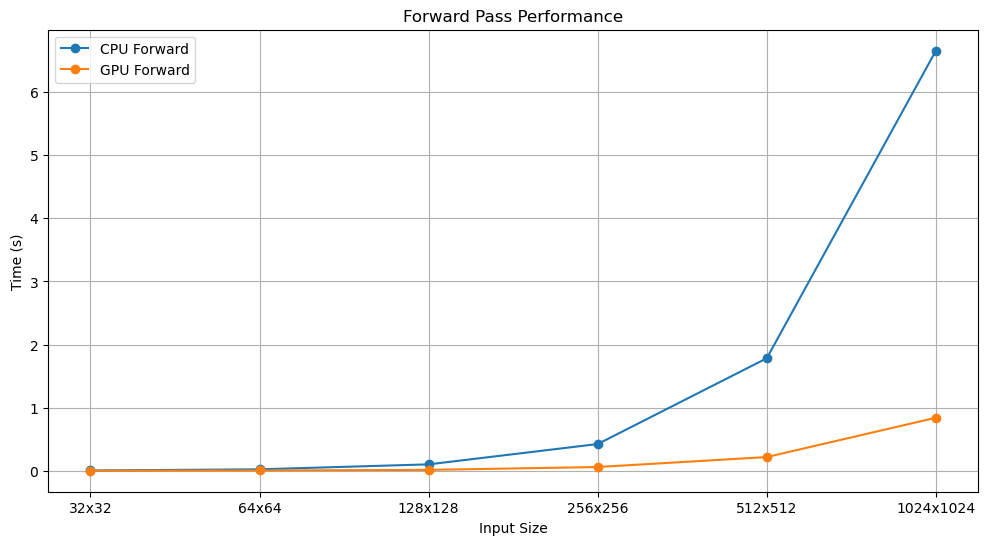

In [52]:
plot_results(data, configs)

### **Conclusion**

This work demonstrated the significant performance improvements achieved by implementing convolution operations on a GPU. By restructuring the convolution process into a matrix multiplication format, the algorithm effectively leveraged parallel computing, resulting in substantial speedups compared to traditional CPU-based implementations.

Also, the research on the numba tool showed that this library still have limitations, related to working with python classes and some numpy operations that was used in introduced functions, consequently magic button didn't work out in this work, I plan to make bigger research on particularly this tool in future educational notebooks.

While this approach showcases the advantages of GPU acceleration, it is important to acknowledge that modern deep learning frameworks, such as PyTorch and TensorFlow, already include highly optimized implementations for convolution operations. These libraries utilize low-level optimizations and specialized hardware instructions to further enhance efficiency.

Despite this, the implementation presented in this work serves as a valuable exercise in understanding GPU-based computations. It provides insights into advanced numpy, matrix transformations, and optimization strategies that are essential for machine learning engineers. This foundational knowledge not only contributes to a deeper comprehension of GPU acceleration but also enhances the ability to optimize and customize algorithms for specific applications.